In [1]:
import os
import sys
import pandas as pd
import numpy as np

# For notebooks — get the current working directory
notebook_dir = os.getcwd()
project_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(project_dir)

# Then import your module
import Utils.functions as data_viz
import Utils.file_io as file_io

from dotenv import load_dotenv
load_dotenv()

False

In [2]:

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay, classification_report

from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier

from sklearn.metrics import precision_recall_curve, auc, average_precision_score, roc_auc_score

from collections import Counter

import matplotlib.pyplot as plt

classifier_models = ['logistic', 'xgb', 'balanced_rf', 'easy_ensemble', 'rf']

dict_classifier_models = {'LogisticRegression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
                          #'xgb': None, 
                          'BalancedRandomForestClassifier': BalancedRandomForestClassifier(n_estimators=200, random_state=42), 
                          'EasyEnsembleClassifier': EasyEnsembleClassifier(n_estimators=200, random_state=42), 
                          'RandomForestClassifier': RandomForestClassifier(class_weight='balanced', criterion='log_loss', random_state=42, n_estimators=200)


}

train_test_split = pd.to_datetime('2015-01-01')
split_at = train_test_split

In [3]:
def trad_model1(train,test,model_name):
    X_train, y_train = train[0], train[1]
    X_test, y_test = test[0], test[1]

    steps = [('scaler', StandardScaler()),
            ('over', SMOTE(random_state=42, sampling_strategy= 0.5)),
            ('under', RandomUnderSampler(random_state=42, sampling_strategy=1.0))
            ]

    match model_name:
        case 'logistic':
            model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

        case 'rf':
            model = RandomForestClassifier(
                class_weight='balanced',
                criterion='log_loss',
                random_state=42,
                n_estimators=100
            )

        case 'xgb':
            num_pos = sum(y_train == 1)
            num_neg = sum(y_train == 0)
            scale = num_neg / num_pos
            model = XGBClassifier(eval_metric='logloss', random_state=42, scale_pos_weight=scale)

        case 'balanced_rf':
            model = BalancedRandomForestClassifier(n_estimators=100, random_state=42)

        case 'easy_ensemble':
            model = EasyEnsembleClassifier(n_estimators=100, random_state=42)

        case _:
            raise ValueError("Unknown model name")
        

    if model_name in ['logistic', 'xgb', 'rf']:
        steps.append(('classifier', model))
        #print(steps)
        pipeline = Pipeline(steps=steps)
    else:
        #print('branched')
        steps.append(('classifier', model))
        pipeline = Pipeline(steps=[steps[0], steps[-1]])

    # Used to debug how SMOTE and RandomUnderSampler handle class imbalance
    """
    X_res, y_res = pipeline[:-1].fit_resample(X_train, y_train)
    counts = Counter(y_res)
    n0 = counts[0]
    n1 = counts[1]
    print(f"N0:N1 ratio = {n0}:{n1} = {n0/n1:.2f}:1")
    """

    pipeline.fit(X_train, y_train)
    probs = pipeline.predict_proba(X_test)[:, 1]
    if model_name in ['balanced_rf', 'rf']:
        y_pred = (probs >= 0.98).astype(int)
    elif model_name in ['easy_ensemble']:
        y_pred = (probs >= 0.15).astype(int)
    elif model_name in ['logistic']:
        y_pred = (probs >= 0.70).astype(int)
    else:
        y_pred = (probs >= 0.35).astype(int)

    precision, recall, thresholds = precision_recall_curve(y_test, probs)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=["No Recession", "Recession"], output_dict=True)
    #auc(recall, precision)
    report["auc_pr"] = auc(recall, precision)
    report["ap_score"]=  average_precision_score(y_test, probs)
    report["auc_roc"]= roc_auc_score(y_test, probs)

    data = {
        'probabilities': probs,
        'model': model,
        'y_pred': y_pred
    }

    return cm, report, data


    #pass


def trad_model_init(train,test,model):
    X_train, y_train = train[0], train[1]
    X_test, y_test = test[0], test[1]

    steps = [
        ('scaler', StandardScaler()),
        ('over', SMOTE(random_state=42, sampling_strategy= 0.5)),
        ('under', RandomUnderSampler(random_state=42, sampling_strategy=1.0))
    ]

    steps1 = [('scaler', StandardScaler())]
    model_name = str(model)
    model_name = model_name.split("(")[0].lower()

    if model_name in ['logisticregression', 'xgbclassifier', 'balancedrandomforestclassifier']:
        steps.append(('classifier', model))
        pipeline = Pipeline(steps=steps)
    else:
        steps1.append(('classifier', model))
        pipeline = Pipeline(steps=steps1)

    pipeline.fit(X_train, y_train)
    #probs = pipeline.predict_proba(X_test))[:, 1]
    X_all = pd.concat([X_train, X_test])
    probs = pipeline.predict_proba(X_all)[:, 1]
    dates_all = pd.to_datetime(X_all.index)
    prob_series = pd.Series(probs, index=dates_all)



    return pipeline, prob_series

def trad_model_fin(test, probs, threshold = None):
    X_test, y_test = test[0], test[1]
    #probs = pipeline.predict_proba(X_test)[:, 1]
    #probs
    if threshold is None:
        threshold = 0.001
    y_pred = (probs >= threshold).astype(int)

    precision, recall, thresholds = precision_recall_curve(y_test, probs)
    #cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=["No Recession", "Recession"], output_dict=True, zero_division=0)
    report["auc_pr"] = auc(recall, precision)
    report["ap_score"]=  average_precision_score(y_test, probs)
    report["auc_roc"]= roc_auc_score(y_test, probs)

    return report




    pass

In [4]:
file_path = f"{project_dir}/Notebooks/Dataset/data_features"

df_features_daily = file_io.input_csv(f"{file_path}_daily")
df_features_weekly = file_io.input_csv(f"{file_path}_weekly")
df_features_monthly = file_io.input_csv(f"{file_path}_monthly")

dict_features = {'Daily': df_features_daily,
                 'Weekly': df_features_weekly,
                 'Monthly': df_features_monthly
} 

DataFrame loaded from /workspaces/RecessionPredictionML/Notebooks/Dataset/data_features_daily.csv
DataFrame loaded from /workspaces/RecessionPredictionML/Notebooks/Dataset/data_features_weekly.csv
DataFrame loaded from /workspaces/RecessionPredictionML/Notebooks/Dataset/data_features_monthly.csv


In [5]:
print(type(dict_features['Daily']))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
classifier_results = {}

for time_freq, df in dict_features.items():
    X = df.drop(columns='recession')
    y = df['recession'] 

    # Train-test split
    #split_at = pd.to_datetime('2015-01-01')
    X_train, X_test = X[X.index < split_at], X[X.index >= split_at]
    y_train, y_test = y[y.index < split_at].astype(int), y[y.index >= split_at].astype(int)

    classifier_results[time_freq] = {}
    for model_name, model in dict_classifier_models.items():
        classifier_results[time_freq][model_name] = {}
        pipeline, probs = trad_model_init([X_train, y_train],[X_test, y_test], model)
        classifier_results[time_freq][model_name]['pipeline'] = pipeline 
        classifier_results[time_freq][model_name]['probs'] = probs 
 

In [ ]:


for time_freq, model_details in classifier_results.items():
    print(time_freq)

    df = dict_features[time_freq]
    X = df.drop(columns='recession')
    y = df['recession']

    # Train-test split
    #split_at = pd.to_datetime('2015-01-01')
    X_test = X[X.index >= split_at]
    y_test = y[y.index >= split_at].astype(int)


    for model_name in dict_classifier_models.keys():
        probs = classifier_results[time_freq][model_name]['probs']
        report = trad_model_fin(probs = probs[split_at:], test = [X_test, y_test], threshold = None)
        classifier_results[time_freq][model_name]['report'] = report
        #print(model_name)
        #print(df)
        

Daily
Weekly
Monthly


In [ ]:
for time_freq in classifier_results.keys():
    for model_name in classifier_results[time_freq].keys():
        print(f"\n=== {time_freq} | {model_name} ===")
        #print("Confusion Matrix:\n", classifier_results[time_freq][f'{model_name}_confusion_matrix'])
        print("Classification Report:")
        print(pd.DataFrame(classifier_results[time_freq][model_name]['report']).transpose())




=== Daily | LogisticRegression ===
Classification Report:
              precision    recall  f1-score      support
No Recession   0.000000  0.000000  0.000000  2470.000000
Recession      0.113742  1.000000  0.204253   317.000000
accuracy       0.113742  0.113742  0.113742     0.113742
macro avg      0.056871  0.500000  0.102126  2787.000000
weighted avg   0.012937  0.113742  0.023232  2787.000000
auc_pr         0.171425  0.171425  0.171425     0.171425
ap_score       0.172114  0.172114  0.172114     0.172114
auc_roc        0.722249  0.722249  0.722249     0.722249

=== Daily | BalancedRandomForestClassifier ===
Classification Report:
              precision    recall  f1-score      support
No Recession   1.000000  0.034008  0.065779  2470.000000
Recession      0.117277  1.000000  0.209934   317.000000
accuracy       0.143882  0.143882  0.143882     0.143882
macro avg      0.558639  0.517004  0.137856  2787.000000
weighted avg   0.899597  0.143882  0.082176  2787.000000
auc_pr         

In [ ]:
print(type(list(classifier_results.keys())))

<class 'list'>


In [ ]:
classifier_results_selective = classifier_results.copy()
keys = list(classifier_results.keys())
for time_freq in list(classifier_results_selective.keys()):
    for model_name in list(classifier_results_selective[time_freq].keys()):
        if classifier_results_selective[time_freq][model_name]['report']['auc_roc'] < 0.5:
            del classifier_results_selective[time_freq][model_name]



In [ ]:
print(len(classifier_results_selective['Daily']))

2


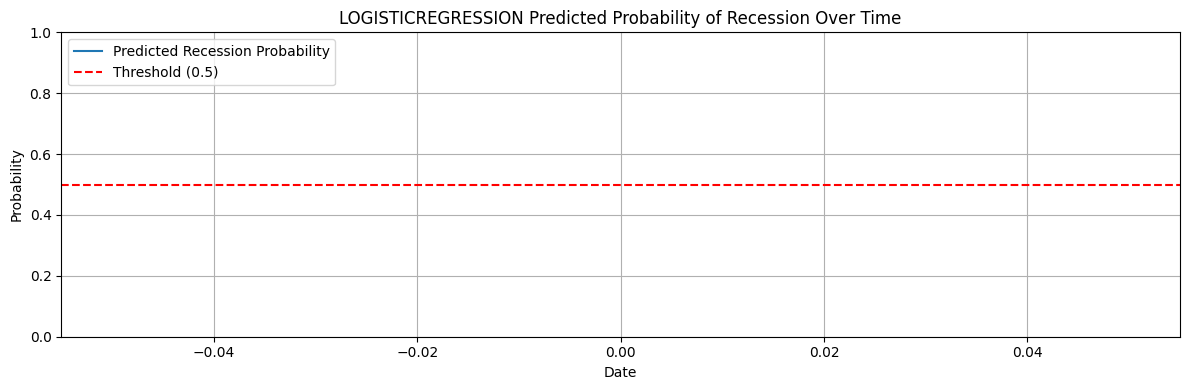

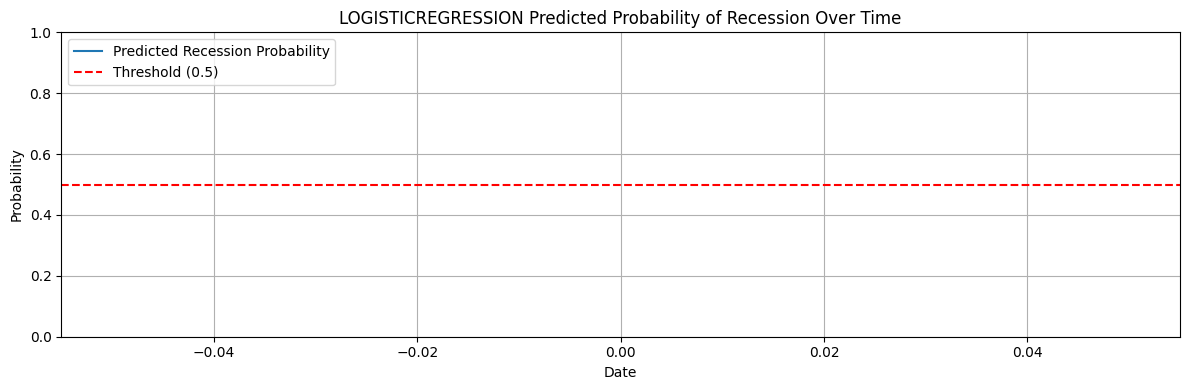

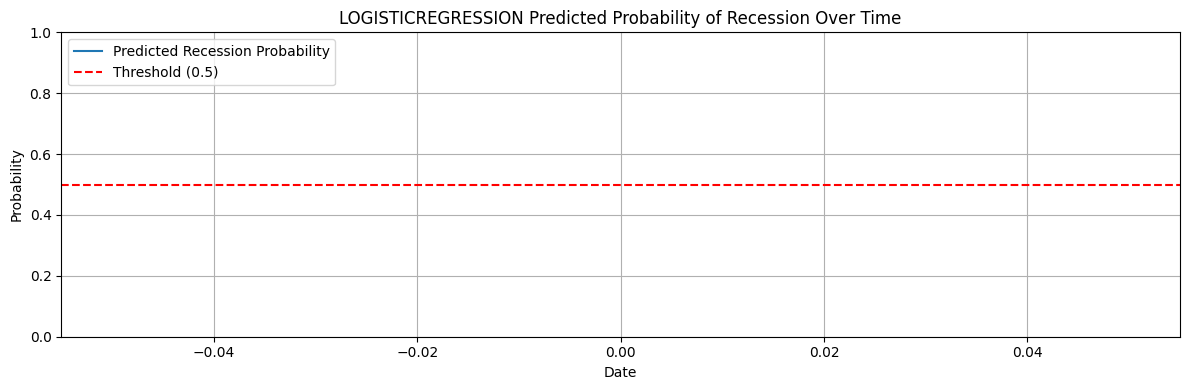

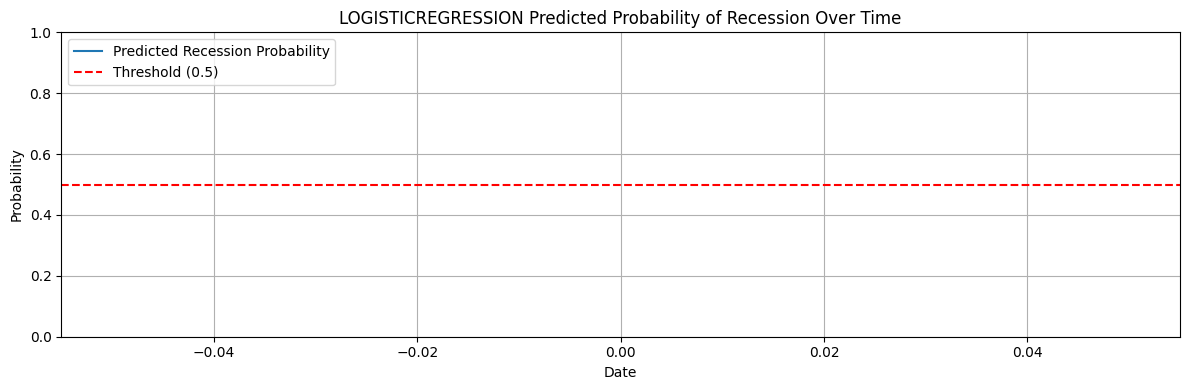

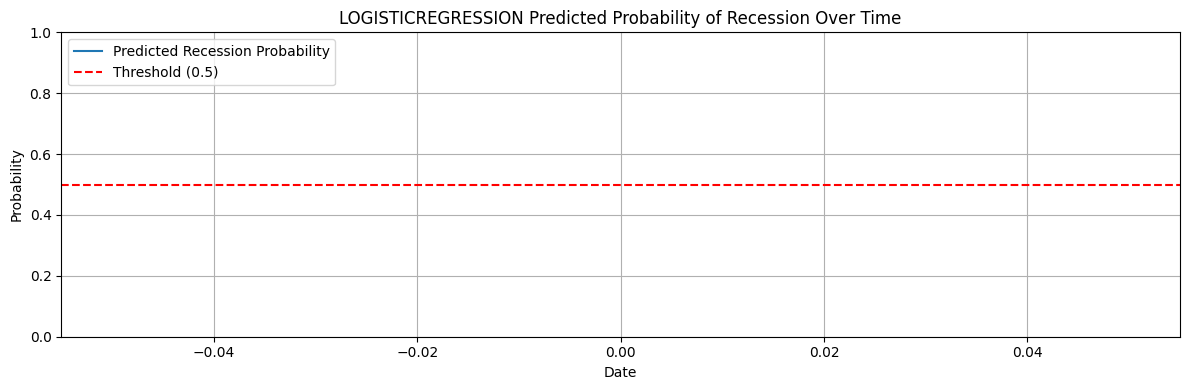

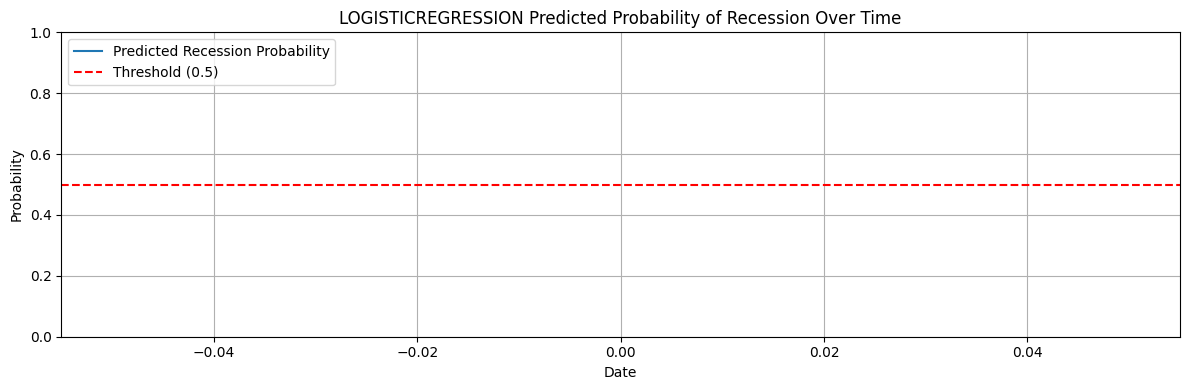

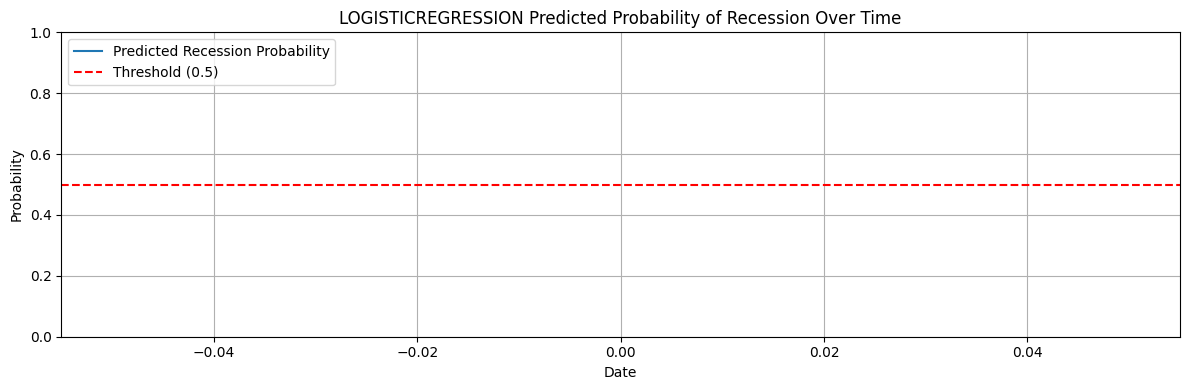

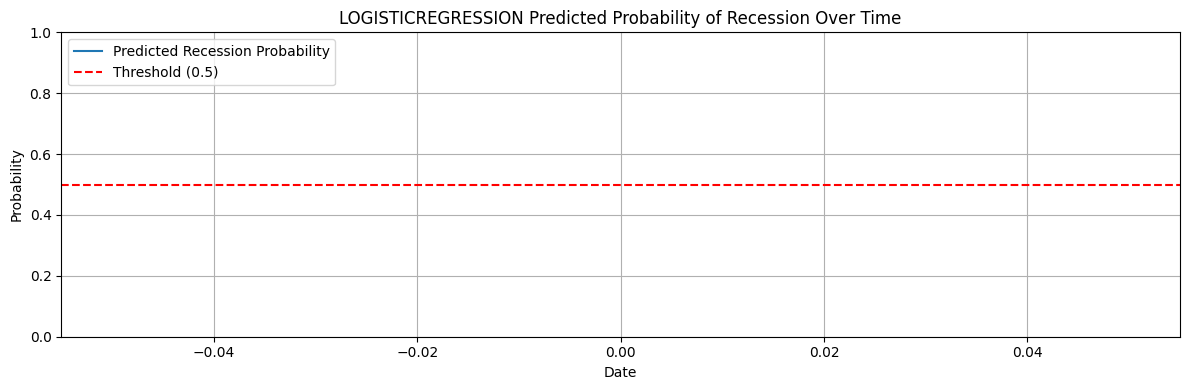

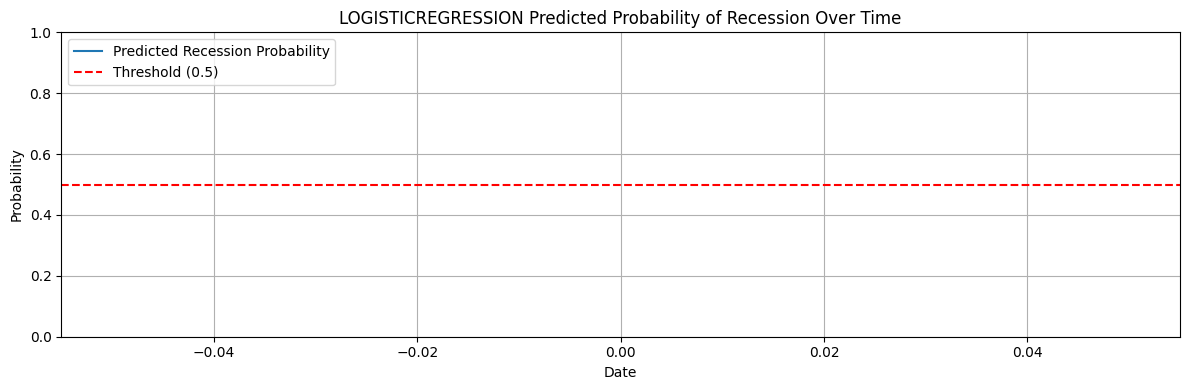

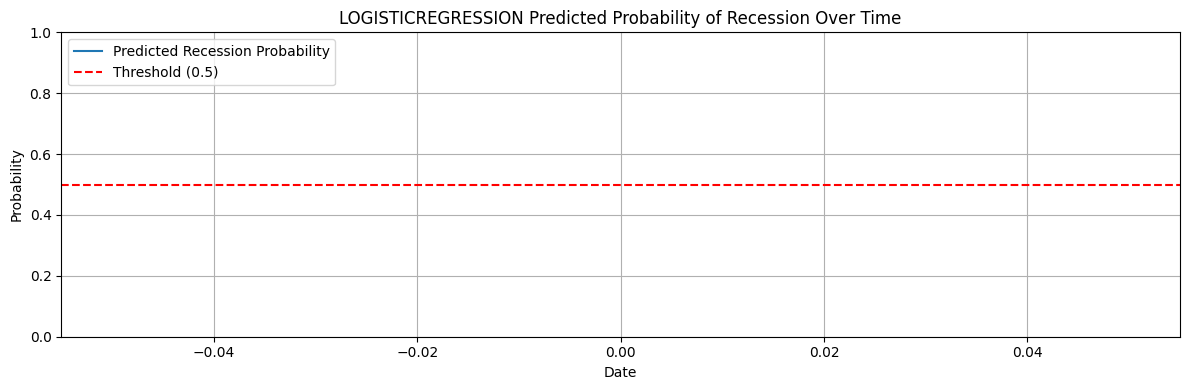

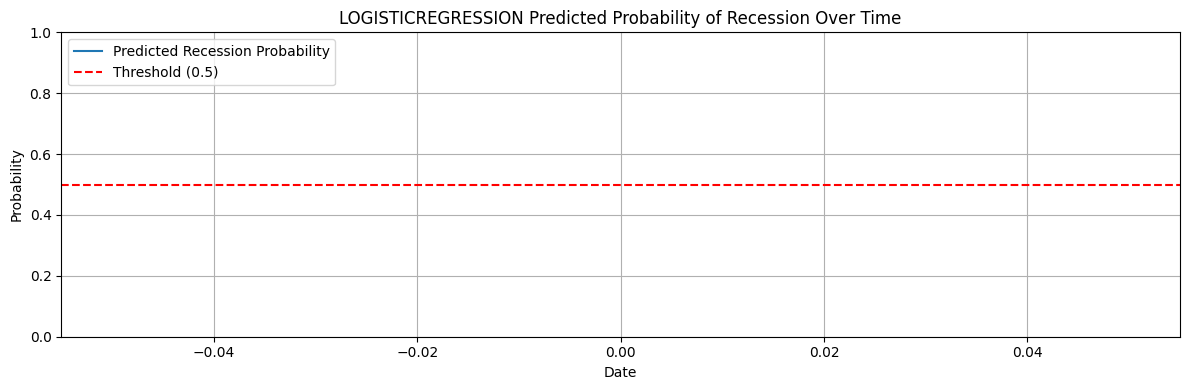

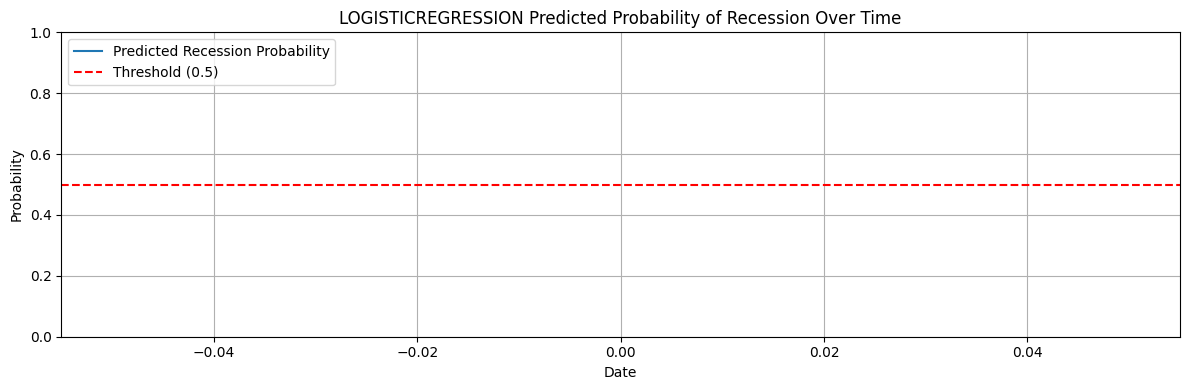

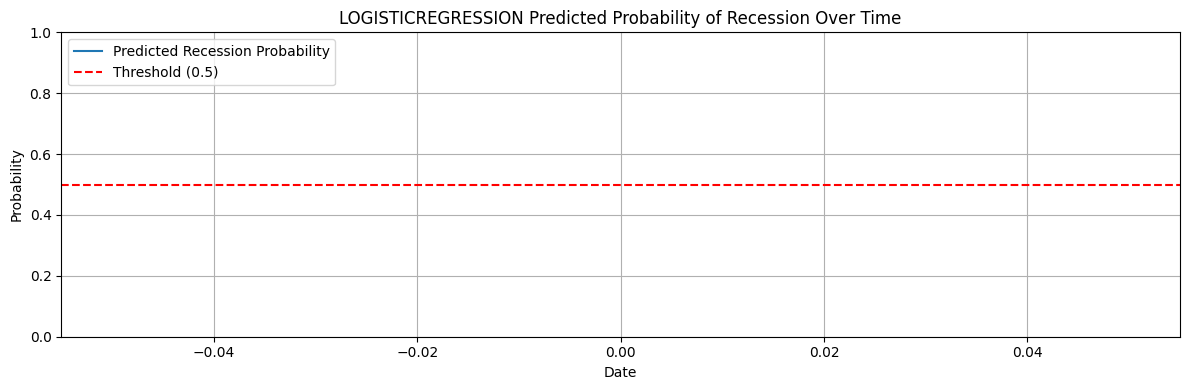

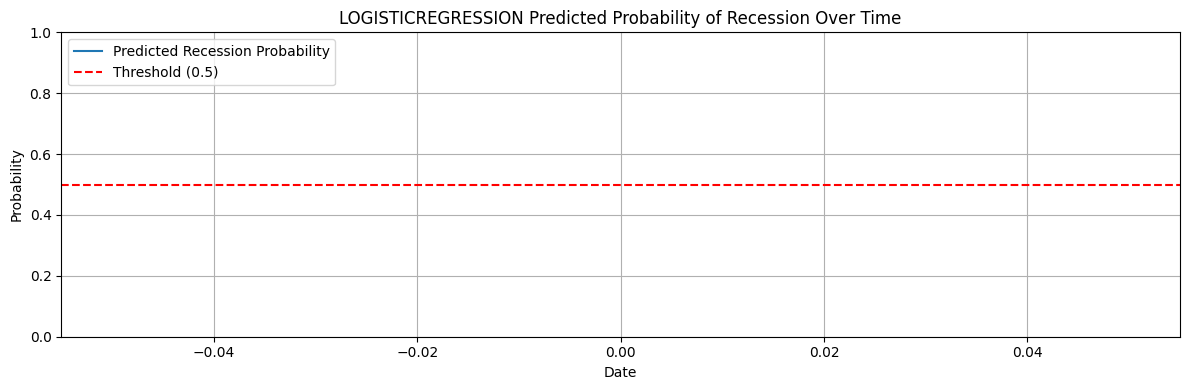

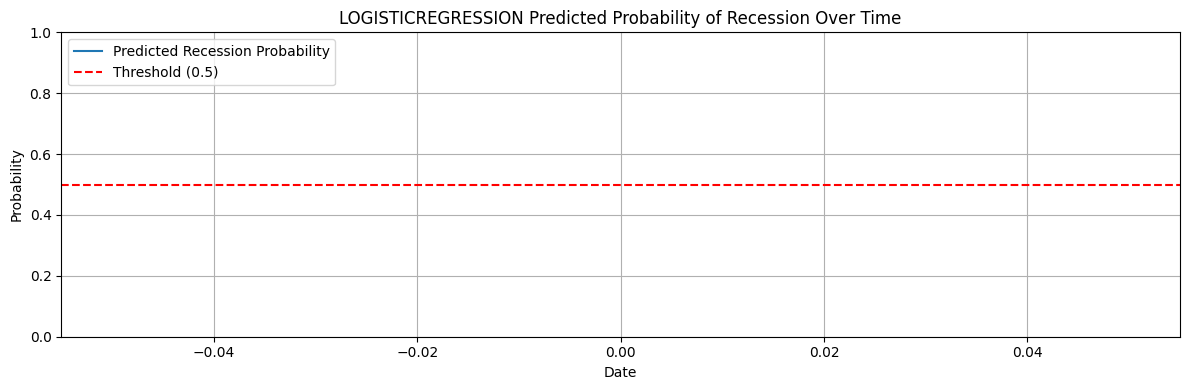

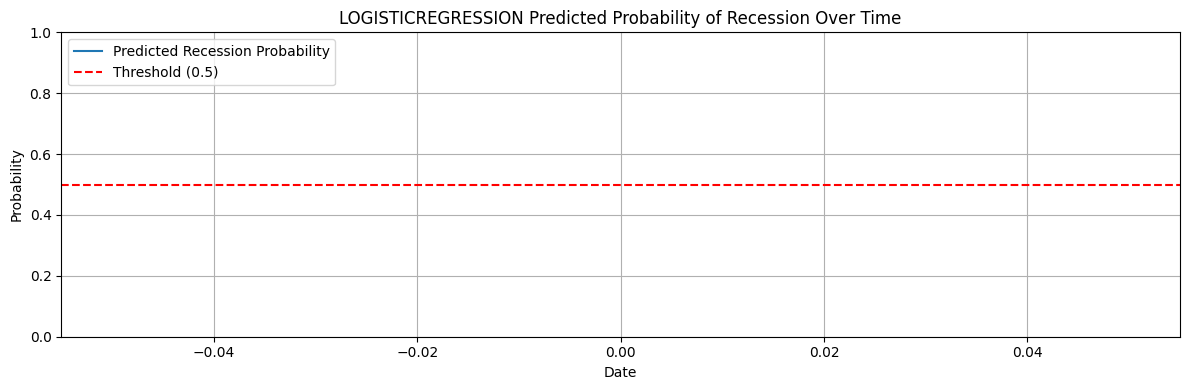

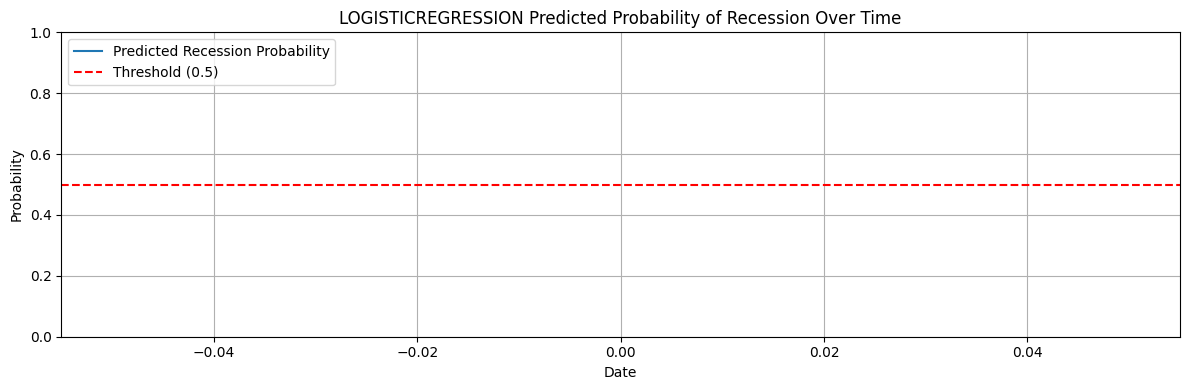

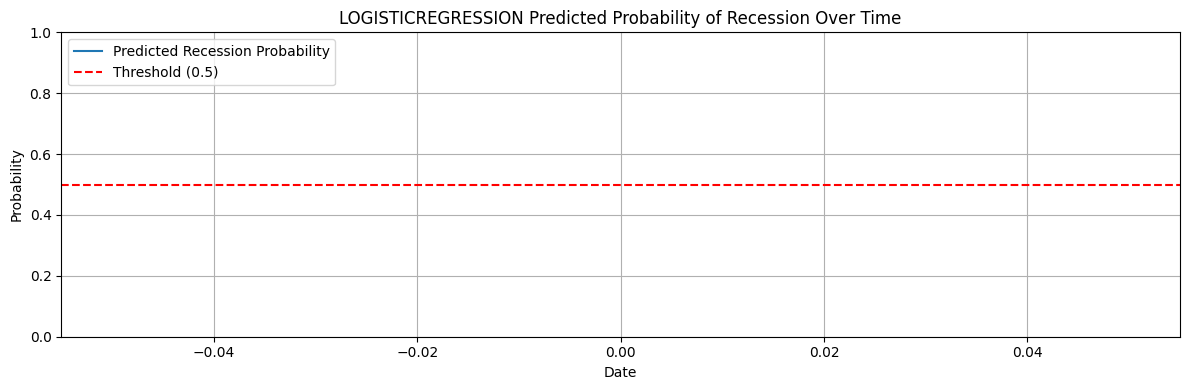

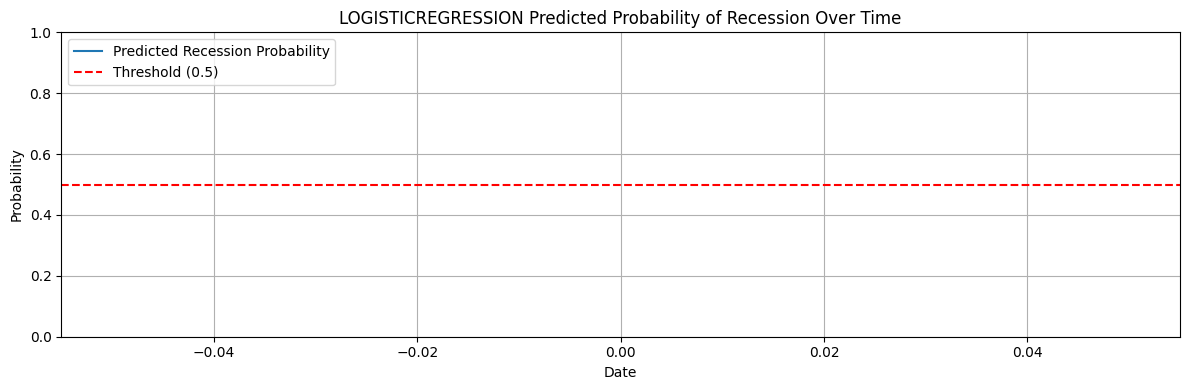

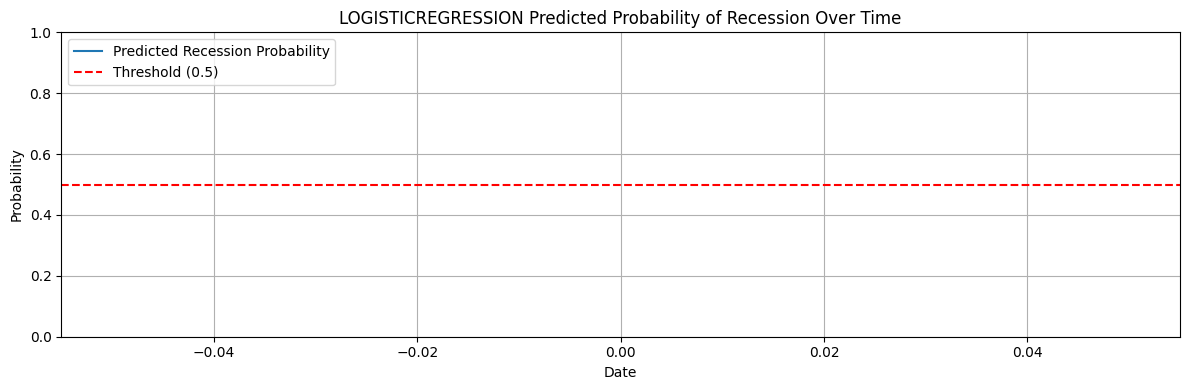

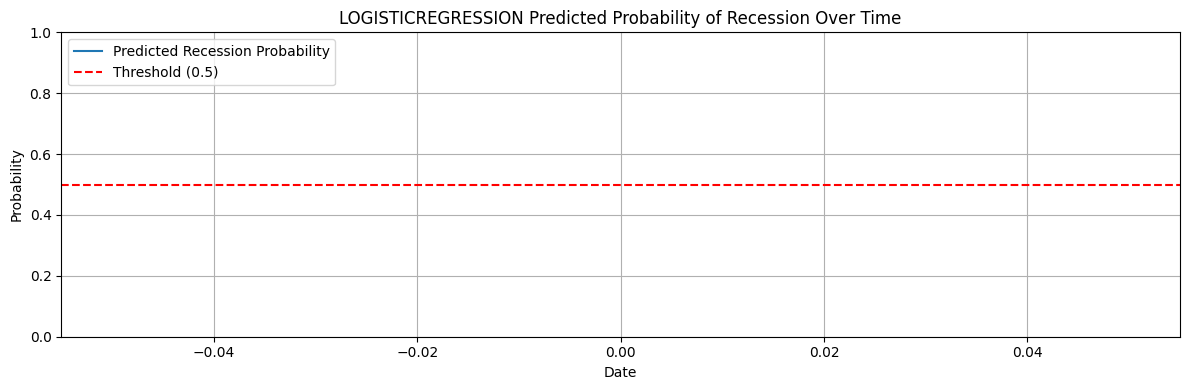

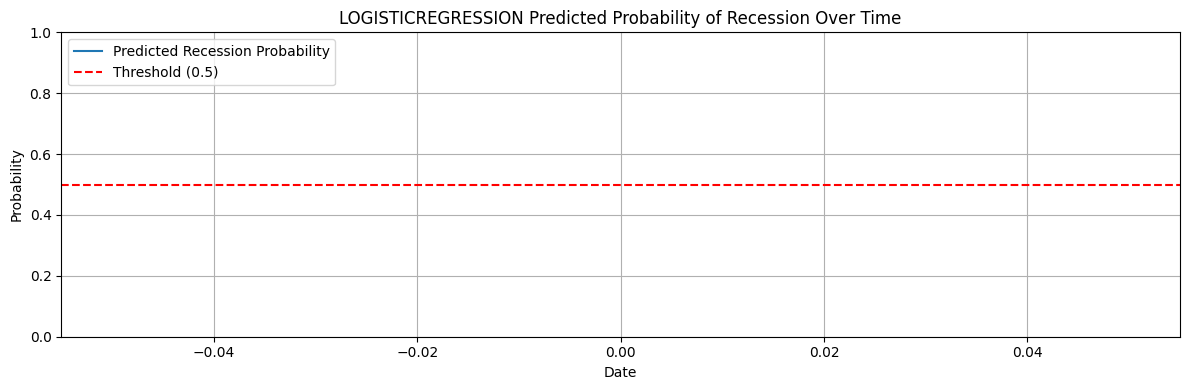

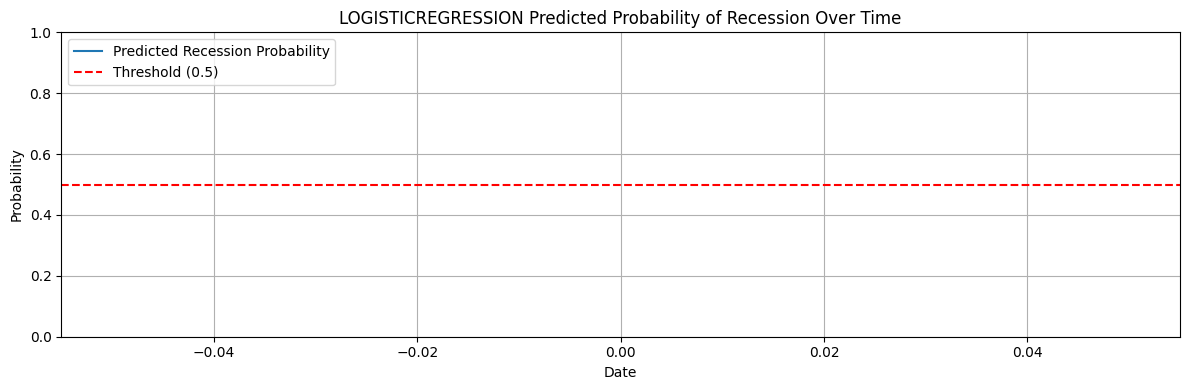

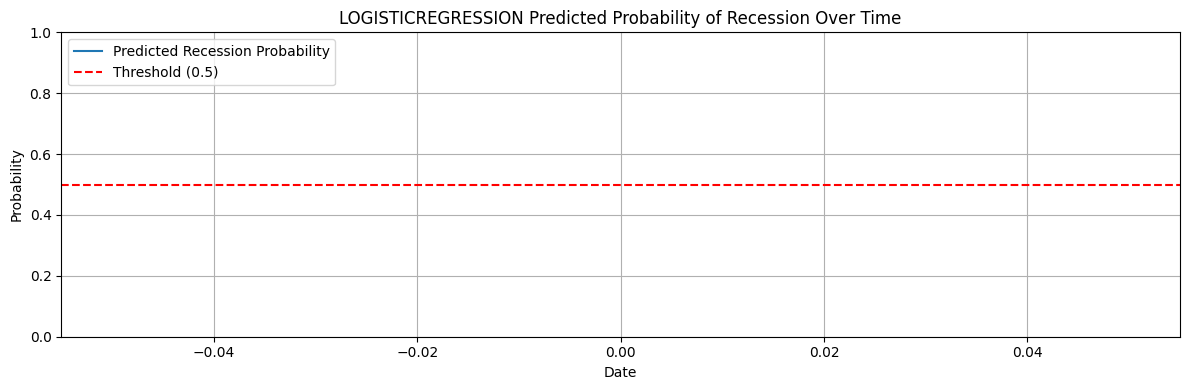

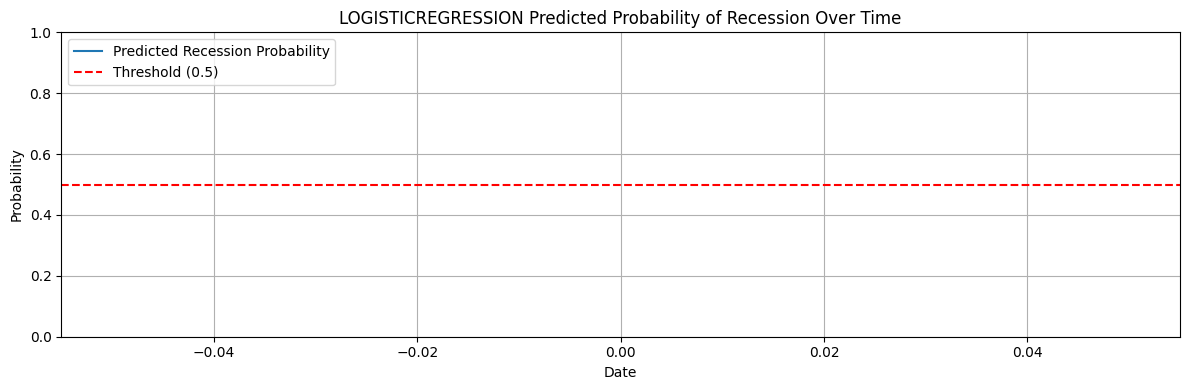

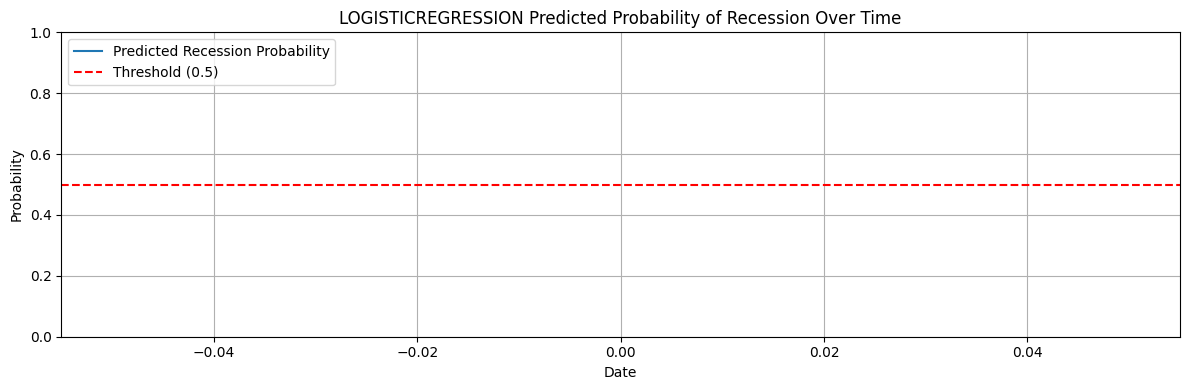

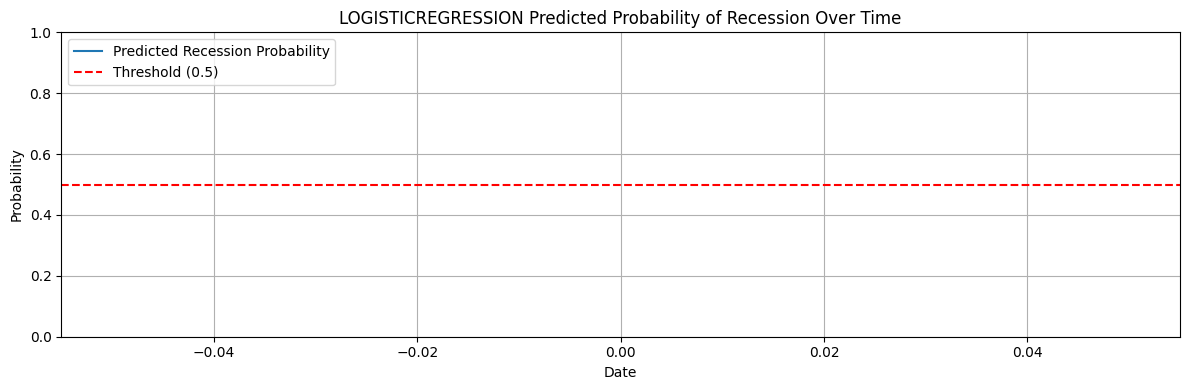

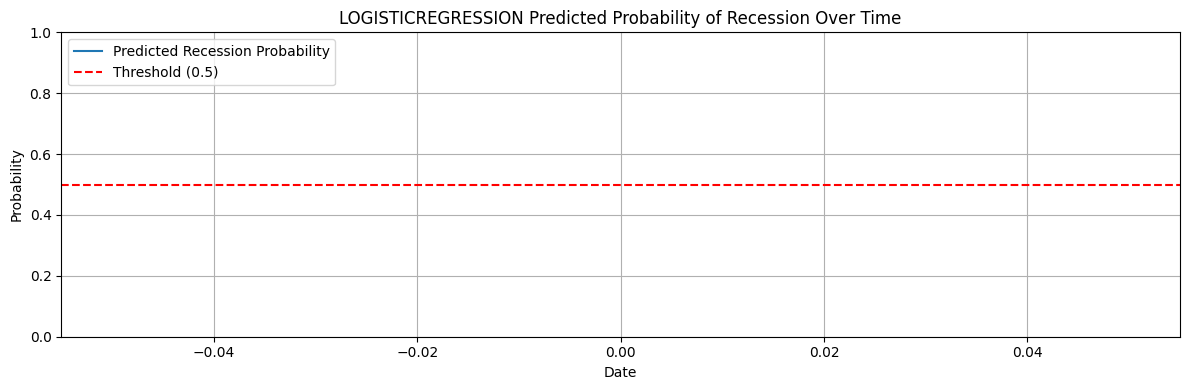

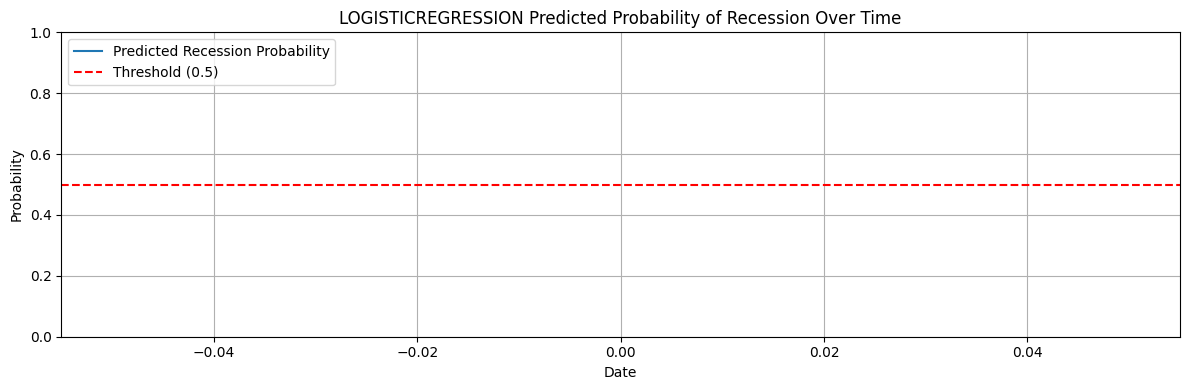

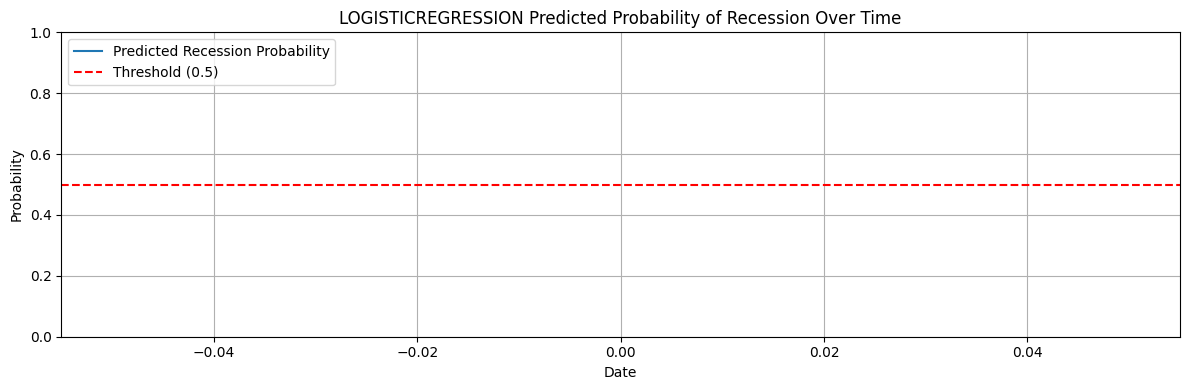

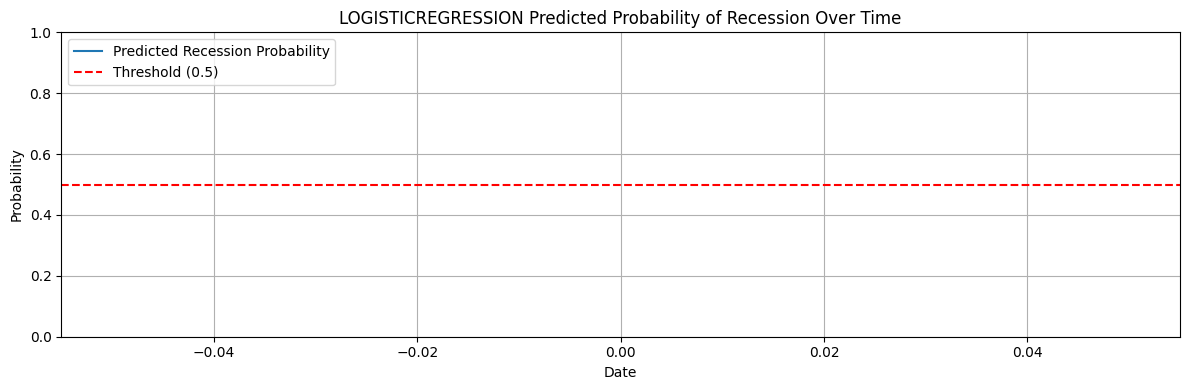

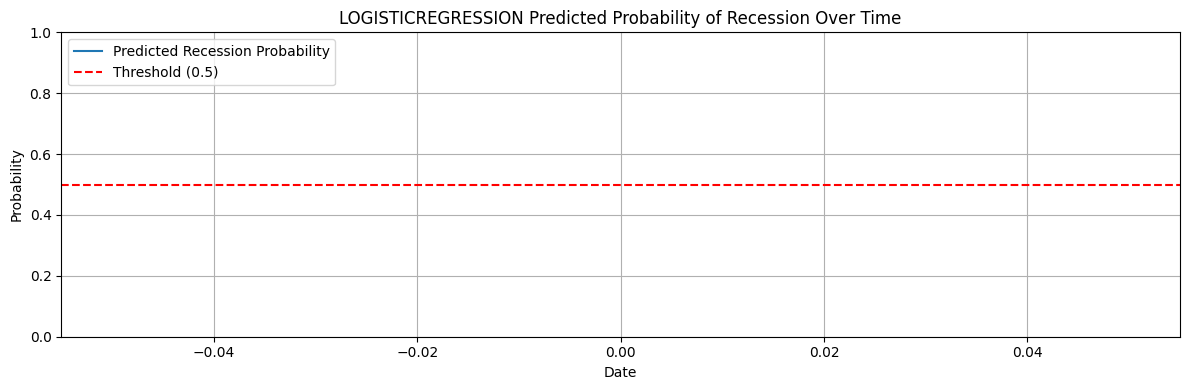

In [ ]:
for time_freq, df in dict_features.items():
    X = df.drop(columns='recession')
    y = df['recession']
    # Train-test split
    #split_at = pd.to_datetime('2015-01-01')
    X_train, X_test = X[X.index < split_at], X[X.index >= split_at]
    y_train, y_test = y[y.index < split_at], y[y.index >= split_at]
    for model_name in classifier_results_selective[time_freq].keys():
        #for pipeline_model in classifier_results_selective[time_freq][model_name]['pipeline']:#.values():
        for prob_series in classifier_results_selective[time_freq][model_name]['probs']:
            #data  = 
            #X_all = X
            #dates_all = pd.to_datetime(X.index)

            # Predict probabilities
            #probs_all = pipeline_model.predict_proba(X_all)[:, 1]
            #prob_series = pd.Series(probs_all, index=dates_all)
            print(prob_series)
            # Plot
            #plt.figure(figsize=(12, 4))
            #plt.plot(prob_series, label='Predicted Recession Probability')
            #if model_name in ['logistic']:
            #    plt.axhline(y=0.4, color='r', linestyle='--', label='Threshold (0.4)')
            #elif model_name in ['balanced_rf','rf']:
            #    plt.axhline(y=0.85, color='r', linestyle='--', label='Threshold (0.8)')
            #else:
            #    plt.axhline(y=0.5, color='r', linestyle='--', label='Threshold (0.5)')
#
            ##if recessions is not None:
            ##    for start, end, color, label_rec in recessions:
            ##        plt.axvspan(start, end, color=color, alpha=0.2, label=label_rec)
#
            ##plt.xlim(0, 1)
            #plt.title(f'{model_name.upper()} Predicted Probability of Recession Over Time')
            #plt.xlabel('Date')
            #plt.ylabel('Probability')
            #handles, labels = plt.gca().get_legend_handles_labels()
            #plt.legend(handles[:2], labels[:2], loc = 'upper left')
            #plt.ylim(0, 1)
            #plt.grid(True)
            #plt.tight_layout()
            #plt.show()

In [ ]:
var = classifier_results_selective['Daily']['LogisticRegression']['probs']#['pipeline']#['auc_roc']
print(len(dict_features["Daily"]))
print(len(var))
print((var))
print(type(var))

for k in var.values():
    print(k)

11598
11598
1981-09-01    0.909247
1981-09-02    0.890807
1981-09-03    0.908683
1981-09-04    0.892180
1981-09-07    0.892180
                ...   
2025-07-11    0.732221
2025-07-14    0.733339
2025-07-15    0.735105
2025-07-16    0.731511
2025-07-17    0.732576
Length: 11598, dtype: float64
<class 'pandas.core.series.Series'>


TypeError: 'numpy.ndarray' object is not callable

In [ ]:
results_classifier = {}

for label, df in dict_features.items():
    X = df.drop(columns='recession')
    y = df['recession']

    # Train-test split
    #split_at = pd.to_datetime('2015-01-01')
    X_train, X_test = X[X.index < split_at], X[X.index >= split_at]
    y_train, y_test = y[y.index < split_at].astype(int), y[y.index >= split_at].astype(int)

    results_classifier[label] = {}
    for model_name in classifier_models:
        results_classifier[label][model_name] = {}
        print(model_name)
        cm,report, data = trad_model1([X_train, y_train], [X_test, y_test], model_name=model_name)
        #results_classifier[label][f'{model_name}_confusion_matrix'] = cm
        #results_classifier[label][f'{model_name}_report'] = report
        results_classifier[label][model_name]['data'] = data



logistic


xgb
balanced_rf
easy_ensemble


/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


rf
logistic
xgb
balanced_rf
easy_ensemble


/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


rf
logistic
xgb
balanced_rf
easy_ensemble
rf


/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print(len(X_train))
print(len(dict_features['Daily'][split_at:]))

400
2787


In [ ]:
print(str(results_classifier['Daily']['logistic']['data']['model']))
ppp= str(results_classifier['Daily']['logistic']['data']['model'])
print((ppp.split("(")[0].lower()))

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
logisticregression


In [ ]:
print(dict_features['Daily'].drop(columns='recession'))
#df.drop(columns='recession')

            GS10_minus_DGS2  GS10_minus_DGS3MO
1981-09-01            -1.46              -1.69
1981-09-02            -1.46              -1.33
1981-09-03            -1.58              -1.64
1981-09-04            -1.57              -1.32
1981-09-07            -1.57              -1.32
...                     ...                ...
2025-07-11             0.48              -0.03
2025-07-14             0.48              -0.04
2025-07-15             0.43              -0.04
2025-07-16             0.50              -0.03
2025-07-17             0.47              -0.03

[11598 rows x 2 columns]


/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


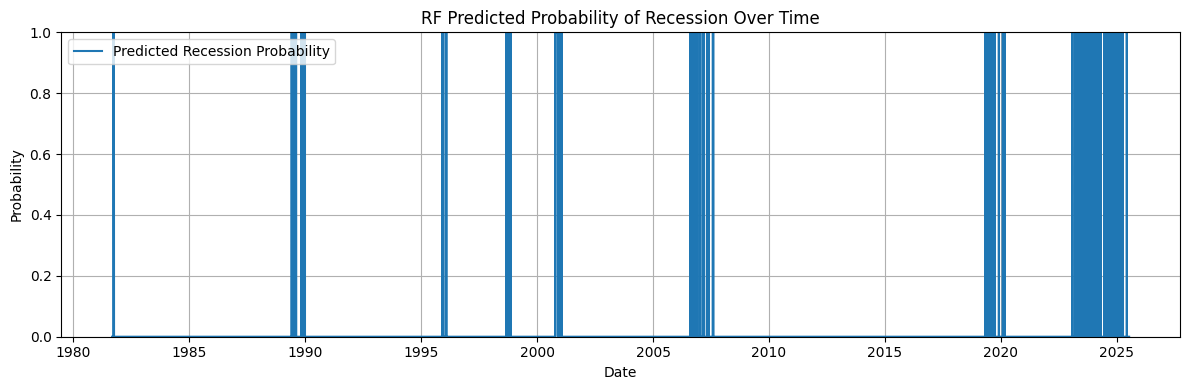

In [ ]:
X_all = dict_features['Daily'].drop(columns='recession')
dates_all = pd.to_datetime(X_all.index)
pipeline = data['model']

probs_all = pipeline.predict_proba(X_all)[:, 1]
prob_series = pd.Series(probs_all, index=dates_all)
y_pred = (prob_series >= 0.92).astype(int)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
#plt.plot(prob_series, label='Predicted Recession Probability')
plt.plot(y_pred, label='Predicted Recession Probability')
plt.title(f'{model_name.upper()} Predicted Probability of Recession Over Time')
plt.xlabel('Date')
plt.ylabel('Probability')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], loc = 'upper left')
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print(results_classifier['Daily']['logistic']['data']['y_pred']) 

[0 0 0 ... 1 1 1]


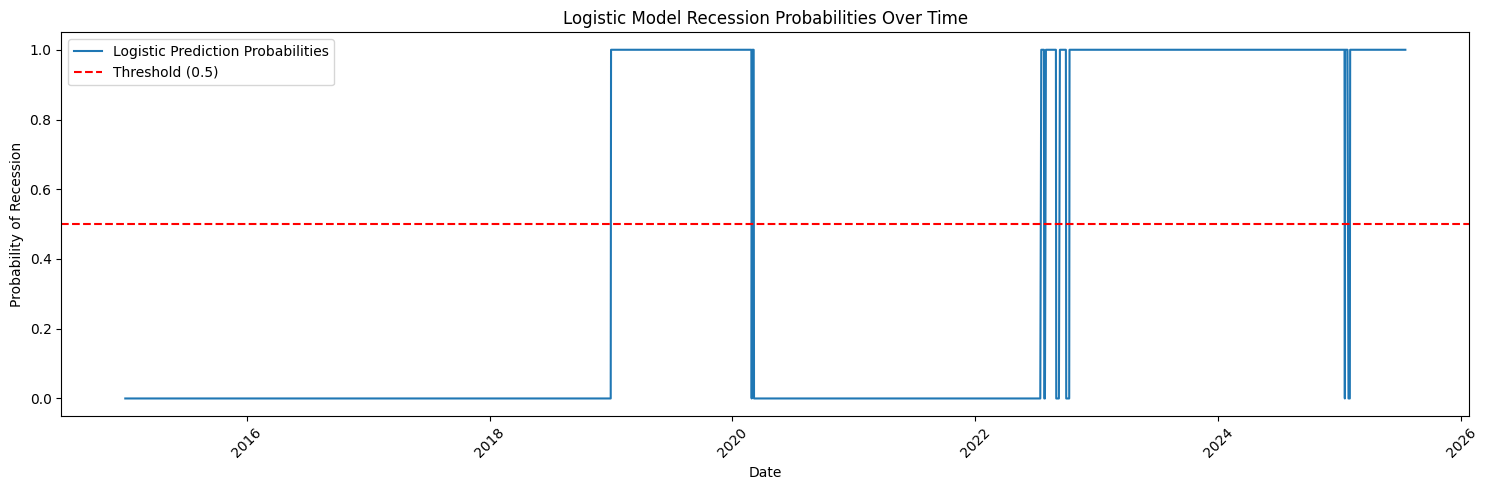

In [ ]:
import matplotlib.pyplot as plt

# Get x and y
x = dict_features['Daily'][split_at:].index
y = results_classifier['Daily']['logistic']['data']['y_pred']

# Check if y is a DataFrame or Series, convert if needed
if isinstance(y, dict) and 'probabilities' in y:
    y = y['probabilities']  # or change this key depending on your data

# Plot
plt.figure(figsize=(15, 5))
plt.plot(x, y, label='Logistic Prediction Probabilities')
plt.xlabel("Date")
plt.ylabel("Probability of Recession")
plt.title("Logistic Model Recession Probabilities Over Time")
plt.axhline(y=0.5, color='red', linestyle='--', label='Threshold (0.5)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
